In [8]:
import pandas as pd
import os
import sys
import glob
import json
from os.path import expanduser
import matplotlib.pyplot as plt                   # For graphics
import numpy as np
from agavepy.agave import Agave, AgaveError
from agavepy.files.download import files_download
%matplotlib inline




%load_ext autoreload
%reload_ext autoreload
%autoreload 2


from pysd2cat.analysis import live_dead_analysis as lda
from pysd2cat.analysis.Names import Names

from pysd2cat.data import pipeline

out_dir='.' # test harness output



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def make_experiment_metadata_dataframe(experiment_id):
    df = pd.DataFrame()
    samples = pipeline.get_experiment_samples(experiment_id,file_type='FCS')
    for sample in samples:
        df = df.append(sample_to_row(sample), ignore_index=True)
    return df

def flatten_sample_contents(feature, value):
    kv_pairs=[]
    for content in value:
        if "name" in content:
            if 'label' in content['name']:
                if content['name']['label'] == 'YPAD':
                    kv_pairs.append(('media', content['name']['label']))
                elif content['name']['label'] == 'Ethanol':
                    kv_pairs.append(('kill_method', 'Ethanol'))
                    if 'volume' in content:
                        if 'unit' in content['volume'] and 'value' in content['volume']:
                            kv_pairs.append(('kill_volume', content['volume']['value']))
                            kv_pairs.append(('kill_volume_unit', content['volume']['unit']))
                        else:
                            raise "Malformed Volume of sample contents: " + str(content['volume'])
                elif content['name']['label'] == 'SYTOX Red Stain':
                    #print(content['name'])
                    kv_pairs.append(('stain', 'SYTOX Red Stain'))
                    if 'volume' in content:
                        if 'unit' in content['volume'] and 'value' in content['volume']:
                            kv_pairs.append(('stain_volume', content['volume']['value']))
                            kv_pairs.append(('stain_volume_unit', content['volume']['unit']))
                        else:
                            raise "Malformed Volume of sample contents: " + str(content['volume'])
                    
    return kv_pairs

def flatten_temperature(feature, value):
    return [(feature, value['value'])]

def flatten_feature(feature, value):
    if feature == 'sample_contents':
        return flatten_sample_contents(feature, value)
    elif feature == 'temperature':
        return flatten_temperature(feature, value)
    else:
        raise "Cannot flatten feature: " + feature

def sample_to_row(sample):
    features = [k for k,v in sample.items() if type(v) is not dict and type(v) is not list]
    row = {}
    for feature in features:
        row[feature] = sample[feature]
        
    #Handle nested features
    for feature in [x for x in sample.keys() if x  not in features]:
        kv_pairs = flatten_feature(feature, sample[feature])
        for k, v in kv_pairs:
            row[k] = v
    return row

def fetch_data(meta_df, data_dir, overwrite=False):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
        
    ag = Agave.restore()

    for i, row in meta_df.iterrows():
        src = row['agave_system'] + row['agave_path']
        dest = data_dir + row['agave_path']

        if overwrite or not os.path.exists(dest):
            result_dir = "/".join((data_dir + row['agave_path']).split('/')[0:-1])
            if not os.path.exists(result_dir):
                os.makedirs(result_dir)

            #print(src)
            print(dest)
            
            files_download(ag.api_server, ag.token.token_info['access_token'], src, dest)
    

In [43]:

    

experiments = [
    'experiment.uw_biofab.34601',
    'experiment.uw_biofab.34600'
]
overwrite=True
   
for experiment in experiments[0:1]:
    data_dir = os.path.join('data/biofab', experiment)
    all_data_file = os.path.join(data_dir, 'data.csv')

    if overwrite or not os.path.exists(all_data_file):
        meta_df = make_experiment_metadata_dataframe(experiment)
        fetch_data(meta_df, data_dir)
        meta_df[Names.FILENAME] = meta_df.apply(lambda x:  data_dir + "/" + x['agave_path'], axis=1)
        all_data_df = pipeline.get_data_and_metadata_df(meta_df, '.', fraction=None, max_records=None)
        all_data_df.to_csv(all_data_file)


record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37842-A01.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37842-A01.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37843-A02.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37843-A02.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37844-A03.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37844-A03.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37877-A04.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37877-A04.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37878-A05.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_2

record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37903-F01.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37903-F01.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37867-F02.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37867-F02.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37886-F03.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37886-F03.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37895-F04.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37895-F04.fcs
record[filename]: data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_211581/37904-F05.fcs
.
data/biofab/experiment.uw_biofab.34601//uploads/biofab/201907/34601/op_2

In [90]:
data_dir = os.path.join('data/biofab', experiments[1])
all_data_file = os.path.join(data_dir, 'data.csv')
experiment_df = pd.read_csv(all_data_file, index_col=0)
experiment_df

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,agave_path,agave_system,challenge_problem,experiment_id,experiment_reference,experiment_reference_url,file_type,filename,hpc_path,jupyter_path,kill_method,kill_volume,kill_volume_unit,lab,level,measurement_type,sample_id,stain,strain,strain_lab_id,strain_sbh_uri,temperature,FSC-A,SSC-A,FL1-A,FL2-A,FL3-A,FL4-A,FSC-H,SSC-H,FL1-H,FL2-H,FL3-H,FL4-H,Width,Time,index,live
0,/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,data-sd2e-community,YEAST_STATES,experiment.uw_biofab.34600,YeastSTATES-LiveDeadClassification,https://docs.google.com/document/d/1ztX-c9e4vplz9lYlHlGOWzGdW5Veb_RleOowb-PQ2tQ,FCS,data/biofab/experiment.uw_biofab.34600//uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/work/projects/SD2E-Community/prod/data/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/home/jupyter/sd2e-community/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,Ethanol,980.0,microliter,uw_biofab,0,FLOW,sample.uw_biofab.395880.experiment.uw_biofab.34600,SYTOX Red Stain,S288c_a,name.uw_biofab.30200,https://hub.sd2e.org/user/sd2e/design/S288c_a/1,30.0,7336606.0,6122010.0,228882.0,69471.0,84146.0,13536.0,3985928.0,4896748.0,92434.0,28046.0,33939.0,5869.0,187.0,154.0,0,0
1,/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,data-sd2e-community,YEAST_STATES,experiment.uw_biofab.34600,YeastSTATES-LiveDeadClassification,https://docs.google.com/document/d/1ztX-c9e4vplz9lYlHlGOWzGdW5Veb_RleOowb-PQ2tQ,FCS,data/biofab/experiment.uw_biofab.34600//uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/work/projects/SD2E-Community/prod/data/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/home/jupyter/sd2e-community/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,Ethanol,980.0,microliter,uw_biofab,0,FLOW,sample.uw_biofab.395880.experiment.uw_biofab.34600,SYTOX Red Stain,S288c_a,name.uw_biofab.30200,https://hub.sd2e.org/user/sd2e/design/S288c_a/1,30.0,604924.0,929560.0,35805.0,11880.0,12201.0,1418.0,847513.0,1146045.0,27810.0,8743.0,8843.0,2424.0,45.0,155.0,1,0
2,/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,data-sd2e-community,YEAST_STATES,experiment.uw_biofab.34600,YeastSTATES-LiveDeadClassification,https://docs.google.com/document/d/1ztX-c9e4vplz9lYlHlGOWzGdW5Veb_RleOowb-PQ2tQ,FCS,data/biofab/experiment.uw_biofab.34600//uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/work/projects/SD2E-Community/prod/data/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/home/jupyter/sd2e-community/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,Ethanol,980.0,microliter,uw_biofab,0,FLOW,sample.uw_biofab.395880.experiment.uw_biofab.34600,SYTOX Red Stain,S288c_a,name.uw_biofab.30200,https://hub.sd2e.org/user/sd2e/design/S288c_a/1,30.0,5352153.0,4124297.0,110151.0,39583.0,39754.0,7890.0,2818214.0,3572327.0,48146.0,17212.0,19618.0,4176.0,154.0,155.0,2,0
3,/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,data-sd2e-community,YEAST_STATES,experiment.uw_biofab.34600,YeastSTATES-LiveDeadClassification,https://docs.google.com/document/d/1ztX-c9e4vplz9lYlHlGOWzGdW5Veb_RleOowb-PQ2tQ,FCS,data/biofab/experiment.uw_biofab.34600//uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/work/projects/SD2E-Community/prod/data/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/home/jupyter/sd2e-community/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,Ethanol,980.0,microliter,uw_biofab,0,FLOW,sample.uw_biofab.395880.experiment.uw_biofab.34600,SYTOX Red Stain,S288c_a,name.uw_biofab.30200,https://hub.sd2e.org/user/sd2e/design/S288c_a/1,30.0,1468757.0,537440.0,22431.0,8949.0,10918.0,673.0,1418876.0,674405.0,17495.0,6380.0,8338.0,1695.0,72.0,155.0,3,0
4,/uploads/biofab/201907/34600/op_211578/37759-A01.fcs,data-sd2e-community,YEAST_STATES,experiment.uw_biofab.34600,YeastSTATES-LiveDeadClassification,https://docs.google.com/document/d/1ztX-c9e4vplz9lYlHlGOWzGdW5Veb_RleOowb-PQ2tQ,FCS,data/biofab/experiment.uw_biofab.34600//uploads/biofab/201907/34600/op_211578/37759-A01.fcs,/work/projects/SD2E-Community/prod/data/uploads/biofab/201907/34600/op_211578/3775

In [26]:
def extract_run(x):
    description = x['Data and Split Description']
    run = run = description.split('_')[0]
    return run

def extract_kill(x):
    description = x['Data and Split Description']
    return float(description.split('_')[-1])

def get_random_state(x):
    return x['Data and Split Description'].split('_')[1]



# data/biofab/experiment.uw_biofab.34600_1_0_64.0

def get_leader_board_df(leader_board):
 
    leader_board = pd.read_html(leader_board)[0]
    leader_board = leader_board.sort_values(by=['Date', 'Time'], ascending=True)

    #leader_board=leader_board.dropna()
    #leader_board = leader_board.loc[leader_board['Data and Split Description'].str.contains('__')]

    leader_board.loc[:, 'run'] = leader_board.apply(extract_run, axis = 1)
    leader_board.loc[:, 'kill'] = leader_board.apply(extract_kill, axis = 1)
    leader_board.loc[:,'random_state'] = leader_board.apply(get_random_state, axis=1)
    return leader_board

def case_exists(leader_board_df, input_file, rand, stain):
    match = leader_board_df.loc[(leader_board_df['run'] == get_run_from_path(input_file)) &(leader_board_df['random_state'] == str(rand)) & (leader_board_df['stain'] == stain)]
    return len(match) > 0
    
leader_board_path=os.path.join(out_dir, 'test_harness_results/custom_classification_leaderboard.html')
leader_board_df = get_leader_board_df(leader_board_path)


In [88]:
strain_column_name='kill_volume'
live_strain_name=0
fcs_columns = ['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 
               'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']


dead_strain_names=[980., 570., 370., 250., 170., 105.,  64., 29]
output_col = 'live_29'
#dat = data[0]
#run_id=dat.split("/")[-1].split('.')[0]
#leader_board_df = get_leader_board_df()
for i in range(0, 5):
    for dead_strain_name in dead_strain_names:
        #dat = [x for x in data if not case_exists(leader_board_df, x, i, True)]
        description=data_dir+"_"+str(i)+"_"+str(live_strain_name)+"_"+str(dead_strain_name)
        lda.write_live_dead_column(all_data_file, strain_column_name, live_strain_name, 
                                   dead_strain_name, output_col, fcs_columns, out_dir, overwrite=False, 
                                   description=description, random_state=i, dry_run=True, feature_importance=True) 



/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:12:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 68.42 seconds
Testing time was: 1.07 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.72 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  EMrEyVwxdVPgP  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:14:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 57.81 seconds
Testing time was: 0.86 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.72 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  6DXGz2BwGlrxY  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:15:27
Normalizing training and testing splits...
Starting Classification training...
Training time was: 53.21 seconds
Testing time was: 1.05 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.11 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QEOE9qJbAgLZ7  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:16:40
Normalizing training and testing splits...
Starting Classification training...
Training time was: 57.27 seconds
Testing time was: 1.07 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.81 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5Mz3Y7Qo81v3Y  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:17:59
Normalizing training and testing splits...
Starting Classification training...
Training time was: 82.98 seconds
Testing time was: 1.97 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.76 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  52oLmL9m6vJNG  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:19:45
Normalizing training and testing splits...
Starting Classification training...
Training time was: 64.58 seconds
Testing time was: 1.35 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.74 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  Q7oLEm3bLE2A3  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:21:15
Normalizing training and testing splits...
Starting Classification training...
Training time was: 130.98 seconds
Testing time was: 3.30 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.73 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                       Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5d9GQxr7785MG  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:23:54
Normalizing training and testing splits...
Starting Classification training...
Training time was: 134.50 seconds
Testing time was: 3.19 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.74 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                     Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QPXVV2j12QNN9  2019-0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:26:35
Normalizing training and testing splits...
Starting Classification training...
Training time was: 70.62 seconds
Testing time was: 0.97 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.51 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  Evpg7L81Xok21  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:28:05
Normalizing training and testing splits...
Starting Classification training...
Training time was: 56.29 seconds
Testing time was: 0.66 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.63 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  azZLEvl61jrP6  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:29:21
Normalizing training and testing splits...
Starting Classification training...
Training time was: 55.58 seconds
Testing time was: 1.05 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.22 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5oMPMmZ3LDVp5  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:30:38
Normalizing training and testing splits...
Starting Classification training...
Training time was: 58.93 seconds
Testing time was: 1.27 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.74 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  EeQoWOVodOo21  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:31:59
Normalizing training and testing splits...
Starting Classification training...
Training time was: 93.26 seconds
Testing time was: 2.03 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.75 seconds

         Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  6yxpq2o16BLY  2019-0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:33:55
Normalizing training and testing splits...
Starting Classification training...
Training time was: 59.77 seconds
Testing time was: 1.26 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.76 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5WDyWwNDaJZZN  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:35:18
Normalizing training and testing splits...
Starting Classification training...
Training time was: 121.41 seconds
Testing time was: 2.90 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.77 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                       Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  6p56peVQQ2DZ3  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:37:45
Normalizing training and testing splits...
Starting Classification training...
Training time was: 135.24 seconds
Testing time was: 3.01 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.78 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                     Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  aY8kqPlwJDa8w  2019-0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:40:28
Normalizing training and testing splits...
Starting Classification training...
Training time was: 77.04 seconds
Testing time was: 1.50 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.15 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  56Y1z9qz287v8  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:42:07
Normalizing training and testing splits...
Starting Classification training...
Training time was: 61.79 seconds
Testing time was: 0.88 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.64 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QaX5GjQ7o5l21  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:44:35
Normalizing training and testing splits...
Starting Classification training...
Training time was: 48.47 seconds
Testing time was: 1.06 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.60 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  Q66PXVM9zJoAr  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:45:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 55.39 seconds
Testing time was: 1.07 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.82 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QgL8QJrVyGDPk  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:46:55
Normalizing training and testing splits...
Starting Classification training...
Training time was: 78.20 seconds
Testing time was: 1.81 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.80 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  52x1ebLE6L63N  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:48:34
Normalizing training and testing splits...
Starting Classification training...
Training time was: 56.41 seconds
Testing time was: 1.26 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.82 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  EMdMwdgQ78BEA  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:49:53
Normalizing training and testing splits...
Starting Classification training...
Training time was: 140.68 seconds
Testing time was: 3.51 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.74 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                       Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5d9AZ16QkA5rM  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:52:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 146.64 seconds
Testing time was: 3.53 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.94 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                     Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5ZMoYzw2wZ3z8  2019-0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:55:35
Normalizing training and testing splits...
Starting Classification training...
Training time was: 82.82 seconds
Testing time was: 1.48 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.32 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  6qqE6aPdZLxYG  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:57:24
Normalizing training and testing splits...
Starting Classification training...
Training time was: 74.51 seconds
Testing time was: 1.50 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.44 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5r2kzdwWNMOJY  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 14:59:01
Normalizing training and testing splits...
Starting Classification training...
Training time was: 69.69 seconds
Testing time was: 1.50 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.73 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  Q6589N9JGgwyo  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:00:37
Normalizing training and testing splits...
Starting Classification training...
Training time was: 62.51 seconds
Testing time was: 1.07 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.42 seconds

         Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QNPgQaqN5oa1  2019-0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:02:01
Normalizing training and testing splits...
Starting Classification training...
Training time was: 87.37 seconds
Testing time was: 2.09 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.76 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  66JWMwb1Q29MG  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:03:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 67.13 seconds
Testing time was: 1.47 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.77 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  6pYzN6ppxrAEq  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:05:22
Normalizing training and testing splits...
Starting Classification training...
Training time was: 131.35 seconds
Testing time was: 3.30 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.75 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                       Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5oNaBqVpmlgxy  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:07:59
Normalizing training and testing splits...
Starting Classification training...
Training time was: 134.43 seconds
Testing time was: 3.83 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.76 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                     Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QoYdoOJ9NZdek  2019-0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:10:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 77.77 seconds
Testing time was: 1.38 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.23 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5RljOqOZ6QlOb  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:12:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 57.38 seconds
Testing time was: 0.86 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 1.73 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5oQpdXZNmlj65  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:13:38
Normalizing training and testing splits...
Starting Classification training...
Training time was: 51.75 seconds
Testing time was: 1.06 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.22 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5MRbxDRJD8xgY  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:14:50
Normalizing training and testing splits...
Starting Classification training...
Training time was: 56.80 seconds
Testing time was: 1.07 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.84 seconds

         Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  5VxVb8wML8xw  2019-0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:16:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 89.73 seconds
Testing time was: 2.07 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.74 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  56rgqD3XN96jN  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:18:03
Normalizing training and testing splits...
Starting Classification training...
Training time was: 69.35 seconds
Testing time was: 1.27 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.74 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  6pbk5GbR5ZjMG  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:19:36
Normalizing training and testing splits...
Starting Classification training...
Training time was: 142.45 seconds
Testing time was: 3.21 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.77 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                       Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  QyZbpgZ71MZqP  2019

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'stain_volume', 'stain_volume_unit', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 15:22:27
Normalizing training and testing splits...
Starting Classification training...
Training time was: 141.08 seconds
Testing time was: 3.47 seconds
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.85 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                     Data and Split Description Normalized Num Features Normalized  Feature Extraction Was Untested Data Predicted
0  EYp6DByPrymp1  2019-0

In [91]:
strain_column_name='kill_volume'
live_strain_name=0
fcs_columns = ['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A',  
               'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']


dead_strain_names=[980., 570., 370., 250., 170., 105.,  64., 29]
output_col = 'live_29'
#dat = data[0]
#run_id=dat.split("/")[-1].split('.')[0]
#leader_board_df = get_leader_board_df()
for i in range(0, 5):
    for dead_strain_name in dead_strain_names:
        #dat = [x for x in data if not case_exists(leader_board_df, x, i, True)]
        description=data_dir+"_"+str(i)+"_"+str(live_strain_name)+"_"+str(dead_strain_name)+"_no_stain"
        lda.write_live_dead_column(all_data_file, strain_column_name, live_strain_name, 
                                   dead_strain_name, output_col, fcs_columns, out_dir, overwrite=False, 
                                   description=description, random_state=i, dry_run=True, feature_importance=False) 



/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:04:16
Normalizing training and testing splits...
Starting Classification training...
Training time was: 110.93 seconds
Testing time was: 1.49 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6pW7VdLqOm5jM  2019-07-26  20:04:16  random_forest_classification  Hamed        2           0.993     0.992              1.0        

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:06:47
Normalizing training and testing splits...
Starting Classification training...
Training time was: 122.93 seconds
Testing time was: 1.99 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  Q6ww2NPPZAPXq  2019-07-26  20:06:47  random_forest_classification  Hamed        2           0.98      0.98               0.998      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:09:30
Normalizing training and testing splits...
Starting Classification training...
Training time was: 182.86 seconds
Testing time was: 3.36 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  a3xBvrV9r2jwd  2019-07-26  20:09:30  random_forest_classification  Hamed        2           0.847     0.847              0.926      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:13:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 178.27 seconds
Testing time was: 5.10 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  QyqQM13RPRVVe  2019-07-26  20:13:10  random_forest_classification  Hamed        2           0.827     0.827              0.911      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:16:52
Normalizing training and testing splits...
Starting Classification training...
Training time was: 161.09 seconds
Testing time was: 3.35 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  aPA6xyYvNyyLo  2019-07-26  20:16:52  random_forest_classification  Hamed        2           0.765     0.765              0.846      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:20:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 162.84 seconds
Testing time was: 4.39 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  QywW9A6beypZr  2019-07-26  20:20:10  random_forest_classification  Hamed        2           0.685     0.685              0.754      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:23:31
Normalizing training and testing splits...
Starting Classification training...
Training time was: 179.79 seconds
Testing time was: 4.75 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5JobmJQNvmeYG  2019-07-26  20:23:31  random_forest_classification  Hamed        2           0.539     0.539              0.554      0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:27:13
Normalizing training and testing splits...
Starting Classification training...
Training time was: 233.90 seconds
Testing time was: 5.22 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                              Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  apm7q6PemXNa6  2019-07-26  20:27:13  random_forest_classification  Hamed        2           0.512     0.512              0.514      0.5

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:31:46
Normalizing training and testing splits...
Starting Classification training...
Training time was: 104.27 seconds
Testing time was: 1.31 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5W8vDv3X8bgk5  2019-07-26  20:31:46  random_forest_classification  Hamed        2           0.993     0.992              1.0        

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:34:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 111.85 seconds
Testing time was: 1.90 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6lMPQJ2NPA7b3  2019-07-26  20:34:10  random_forest_classification  Hamed        2           0.98      0.98               0.998      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:36:38
Normalizing training and testing splits...
Starting Classification training...
Training time was: 144.70 seconds
Testing time was: 3.36 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5V6YLyobOpB6w  2019-07-26  20:36:38  random_forest_classification  Hamed        2           0.846     0.846              0.926      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:39:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 159.02 seconds
Testing time was: 3.57 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  agmmDRLG3yvQm  2019-07-26  20:39:41  random_forest_classification  Hamed        2           0.826     0.826              0.911      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:42:58
Normalizing training and testing splits...
Starting Classification training...
Training time was: 154.70 seconds
Testing time was: 3.95 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  QPPPD9Og7W6zr  2019-07-26  20:42:58  random_forest_classification  Hamed        2           0.766     0.766              0.847      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:46:12
Normalizing training and testing splits...
Starting Classification training...
Training time was: 162.33 seconds
Testing time was: 4.25 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  QMrgDBvPJE2MD  2019-07-26  20:46:12  random_forest_classification  Hamed        2           0.685     0.685              0.753      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:49:35
Normalizing training and testing splits...
Starting Classification training...
Training time was: 175.62 seconds
Testing time was: 5.00 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5OWXEMXolexPy  2019-07-26  20:49:35  random_forest_classification  Hamed        2           0.541     0.541              0.557      0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:53:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 213.74 seconds
Testing time was: 5.01 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                              Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6gX1o85wRZ1Qw  2019-07-26  20:53:10  random_forest_classification  Hamed        2           0.511     0.511              0.516      0.5

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:57:21
Normalizing training and testing splits...
Starting Classification training...
Training time was: 102.95 seconds
Testing time was: 1.27 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5M3Xzg1O1yLP5  2019-07-26  20:57:21  random_forest_classification  Hamed        2           0.993     0.992              1.0        

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 20:59:39
Normalizing training and testing splits...
Starting Classification training...
Training time was: 113.86 seconds
Testing time was: 1.81 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6A87l5q1d3l2w  2019-07-26  20:59:39  random_forest_classification  Hamed        2           0.98      0.98               0.998      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:02:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 146.38 seconds
Testing time was: 3.16 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  a7DkRA6GdJqrm  2019-07-26  21:02:10  random_forest_classification  Hamed        2           0.847     0.847              0.927      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:05:14
Normalizing training and testing splits...
Starting Classification training...
Training time was: 153.36 seconds
Testing time was: 3.17 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  Eo9BNgpJoajJy  2019-07-26  21:05:14  random_forest_classification  Hamed        2           0.828     0.828              0.911      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:08:26
Normalizing training and testing splits...
Starting Classification training...
Training time was: 155.69 seconds
Testing time was: 3.85 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  ERBDXdrJlOqGJ  2019-07-26  21:08:26  random_forest_classification  Hamed        2           0.765     0.765              0.847      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:11:42
Normalizing training and testing splits...
Starting Classification training...
Training time was: 160.52 seconds
Testing time was: 4.07 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6Omk3mmr5lXkl  2019-07-26  21:11:42  random_forest_classification  Hamed        2           0.686     0.686              0.753      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:15:02
Normalizing training and testing splits...
Starting Classification training...
Training time was: 174.42 seconds
Testing time was: 4.81 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  Q76wezZ7QXel7  2019-07-26  21:15:02  random_forest_classification  Hamed        2           0.54      0.54               0.555      0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:18:38
Normalizing training and testing splits...
Starting Classification training...
Training time was: 217.60 seconds
Testing time was: 5.02 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                              Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  Ee9pAVZR1OVg8  2019-07-26  21:18:38  random_forest_classification  Hamed        2           0.51      0.51               0.514      0.5

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:22:54
Normalizing training and testing splits...
Starting Classification training...
Training time was: 102.43 seconds
Testing time was: 1.28 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5RjAQrRrGaqyM  2019-07-26  21:22:54  random_forest_classification  Hamed        2           0.994     0.993              0.999      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:25:12
Normalizing training and testing splits...
Starting Classification training...
Training time was: 111.75 seconds
Testing time was: 1.72 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  aWBG1mO6zo9vw  2019-07-26  21:25:12  random_forest_classification  Hamed        2           0.981     0.981              0.998      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:27:41
Normalizing training and testing splits...
Starting Classification training...
Training time was: 146.00 seconds
Testing time was: 2.95 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  52gdDdmP6QaJY  2019-07-26  21:27:41  random_forest_classification  Hamed        2           0.847     0.847              0.927      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:30:45
Normalizing training and testing splits...
Starting Classification training...
Training time was: 147.29 seconds
Testing time was: 3.14 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6DbaeV3kmzwAW  2019-07-26  21:30:45  random_forest_classification  Hamed        2           0.828     0.828              0.911      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:33:49
Normalizing training and testing splits...
Starting Classification training...
Training time was: 153.20 seconds
Testing time was: 4.07 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6drGolJg2ypR3  2019-07-26  21:33:49  random_forest_classification  Hamed        2           0.766     0.766              0.848      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:37:02
Normalizing training and testing splits...
Starting Classification training...
Training time was: 159.45 seconds
Testing time was: 3.99 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5RYJQLaQj6MAN  2019-07-26  21:37:02  random_forest_classification  Hamed        2           0.688     0.688              0.757      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:40:24
Normalizing training and testing splits...
Starting Classification training...
Training time was: 177.53 seconds
Testing time was: 4.47 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6ORy3YGEO8v5Y  2019-07-26  21:40:24  random_forest_classification  Hamed        2           0.541     0.541              0.557      0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:44:03
Normalizing training and testing splits...
Starting Classification training...
Training time was: 219.04 seconds
Testing time was: 4.90 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                              Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  ERm1OBB2YeQXP  2019-07-26  21:44:03  random_forest_classification  Hamed        2           0.512     0.512              0.516      0.5

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:48:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 98.01 seconds
Testing time was: 1.30 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  EopmvPqY9oGYy  2019-07-26  21:48:20  random_forest_classification  Hamed        2           0.993     0.992              1.0        1

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:50:34
Normalizing training and testing splits...
Starting Classification training...
Training time was: 111.46 seconds
Testing time was: 1.83 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  6g5jZDoX2z7MO  2019-07-26  21:50:34  random_forest_classification  Hamed        2           0.982     0.982              0.998      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:54:07
Normalizing training and testing splits...
Starting Classification training...
Training time was: 147.00 seconds
Testing time was: 2.96 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5OVlRrR7yZBwM  2019-07-26  21:54:07  random_forest_classification  Hamed        2           0.846     0.846              0.927      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 21:57:09
Normalizing training and testing splits...
Starting Classification training...
Training time was: 144.94 seconds
Testing time was: 3.16 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  66vlR87gz29mW  2019-07-26  21:57:09  random_forest_classification  Hamed        2           0.828     0.828              0.911      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 22:00:10
Normalizing training and testing splits...
Starting Classification training...
Training time was: 153.56 seconds
Testing time was: 3.96 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  amlDpakExVDJm  2019-07-26  22:00:10  random_forest_classification  Hamed        2           0.764     0.764              0.845      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 22:03:21
Normalizing training and testing splits...
Starting Classification training...
Training time was: 163.29 seconds
Testing time was: 3.95 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                 Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  5235eXe2akZoY  2019-07-26  22:03:21  random_forest_classification  Hamed        2           0.685     0.685              0.752      

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 22:06:42
Normalizing training and testing splits...
Starting Classification training...
Training time was: 178.96 seconds
Testing time was: 5.38 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                                Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  a7NAlqz3R2ZBo  2019-07-26  22:06:42  random_forest_classification  Hamed        2           0.54      0.54               0.554      0

/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time', 'index', 'live']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H']

HI
----------------------------------------------------------------------------------------------------
Starting run at time 22:10:20
Normalizing training and testing splits...
Starting Classification training...
Training time was: 215.31 seconds
Testing time was: 5.11 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                              Data and Split Description Normalized Num Features Normalized Feature Extraction Was Untested Data Predicted
0  522N6ZWvbb2mY  2019-07-26  22:10:20  random_forest_classification  Hamed        2           0.509     0.509              0.514      0.5

In [82]:
# Make predictions for all ethanol volumes by building a model from highest ethanol volume
strain_column_name='kill_volume'
live_strain_name=0
fcs_columns = ['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 
               'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']


dead_strain_names=[980.]
output_col = 'live'
#dat = data[0]
#run_id=dat.split("/")[-1].split('.')[0]
#leader_board_df = get_leader_board_df()
for i in range(5, 6):
    for dead_strain_name in dead_strain_names:
        #dat = [x for x in data if not case_exists(leader_board_df, x, i, True)]
        description=data_dir+"_"+str(i)+"_"+str(live_strain_name)+"_"+str(dead_strain_name)
        lda.write_live_dead_column(all_data_file, strain_column_name, live_strain_name, 
                                   dead_strain_name, output_col, fcs_columns, out_dir, overwrite=True, 
                                   description=description, random_state=i, dry_run=False, feature_importance=True) 



/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (11,13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Computing live/dead for: data/biofab/experiment.uw_biofab.34600/data.csv
data_columns: ['agave_path', 'agave_system', 'challenge_problem', 'experiment_id', 'experiment_reference', 'experiment_reference_url', 'file_type', 'filename', 'hpc_path', 'jupyter_path', 'kill_method', 'kill_volume', 'kill_volume_unit', 'lab', 'level', 'measurement_type', 'sample_id', 'stain', 'strain', 'strain_lab_id', 'strain_sbh_uri', 'temperature', 'FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H', 'Width', 'Time']


/Users/danbryce/Documents/sift/xplan/external/xplan/xplan-to-autoprotocol-reactor/xplan-dev-env/xplan-dev-env/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['FSC-A', 'SSC-A', 'FL1-A', 'FL2-A', 'FL3-A', 'FL4-A', 'FSC-H', 'SSC-H', 'FL1-H', 'FL2-H', 'FL3-H', 'FL4-H']

----------------------------------------------------------------------------------------------------
Starting run at time 11:04:55
Normalizing training and testing splits...
Starting Classification training...
Training time was: 86.77 seconds
Testing time was: 1.28 seconds
Prediction time of untested data was: 38.17168211936951
Starting Feature Extraction...
Feature Extraction time with method rfpimp_permutation was: 2.01 seconds

          Run ID        Date      Time                    Model Name Model Author Num Classes  Accuracy  Balanced Accuracy  AUC Score  Average Precision  F1 Score  Precision  Recall Samples In Train Samples In Test                                                                                      Model Description Column Predicted Num Features Used                        Data and Split Description Normalized Num Features Normalized  Feature Extracti

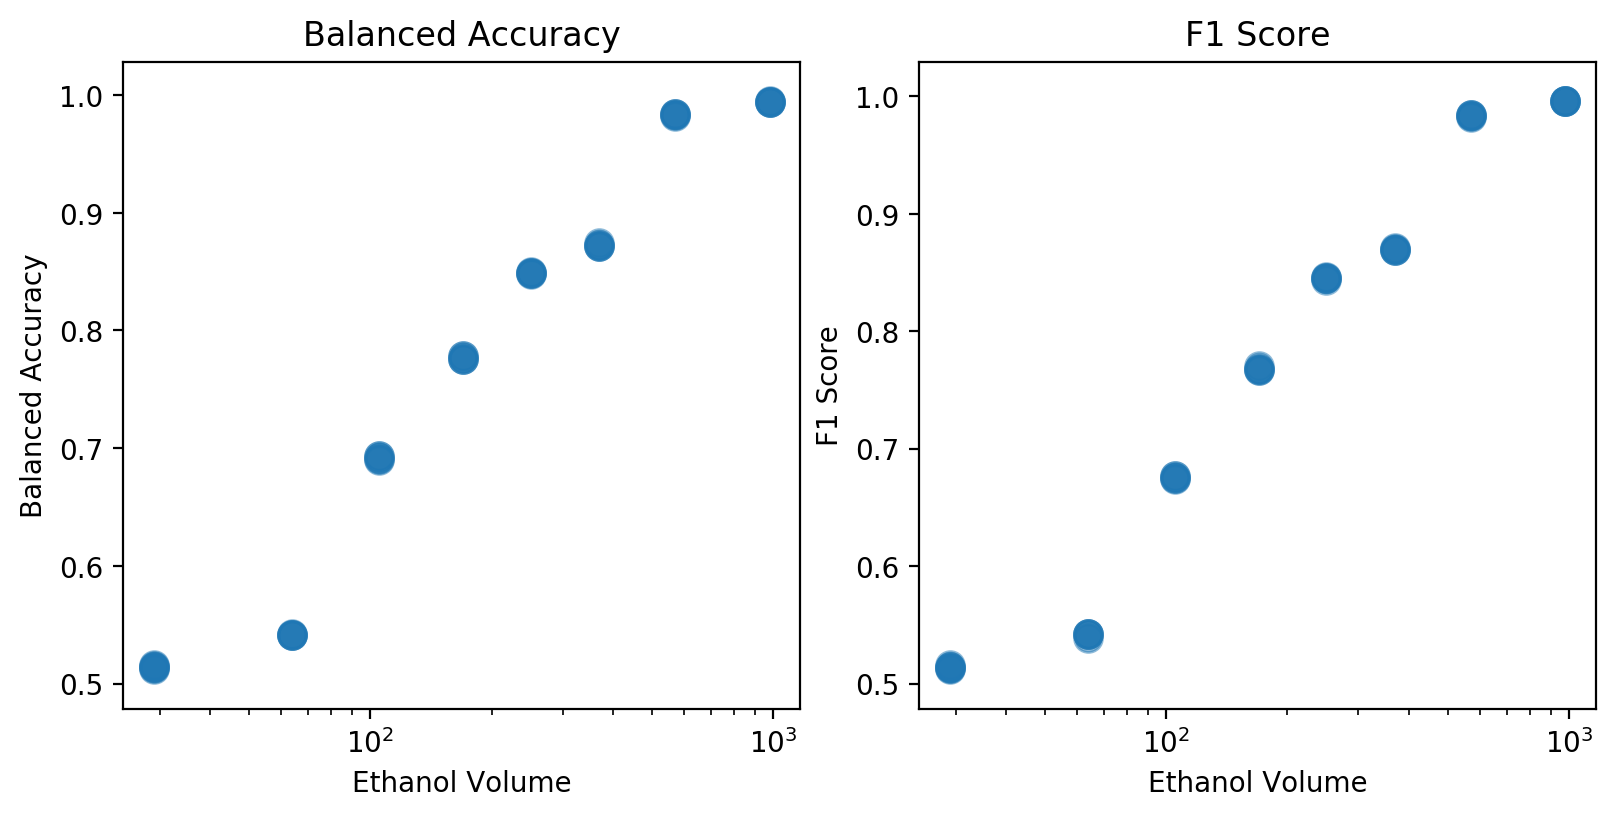

In [31]:
import matplotlib.pyplot as plt                   # For graphics
import numpy as np
%matplotlib inline


#metric='F1 Score'
#metric='Accuracy'
#metrics=['Balanced Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics=['Balanced Accuracy', 'F1 Score']

fig, ax = plt.subplots(nrows=1, ncols=len(metrics), figsize=(4*len(metrics), 4), dpi=200)
#plt.rcParams['font.size'] = 1
plot_df=leader_board_df
for j, col in enumerate(ax):

    #for rs in plot_df.kill.unique():
    df = plot_df

    yvals=df[metrics[j]]
    xvals=df['kill']


    col.set_xlabel("Ethanol Volume")
    col.set_ylabel(metrics[j])

    col.scatter(xvals, yvals,s=100, alpha=0.5)

    lims = [ .65, 1
    ]

    #col.plot(lims, lims, 'k-', alpha=0.1, zorder=0)
    col.set_title(metrics[j])
    col.set_xscale('log')
    #col.set_xlim([0.65, 1])
    #col.set_ylim([0.65, 1])
    #col.set(adjustable='box', aspect='equal')
    #plt.axis([0.85, 1, 0.85, 1])
    #plt.legend()
    #plt.axis('equal')
    #plt.gca().set_aspect('equal', adjustable='box')



plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)






No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


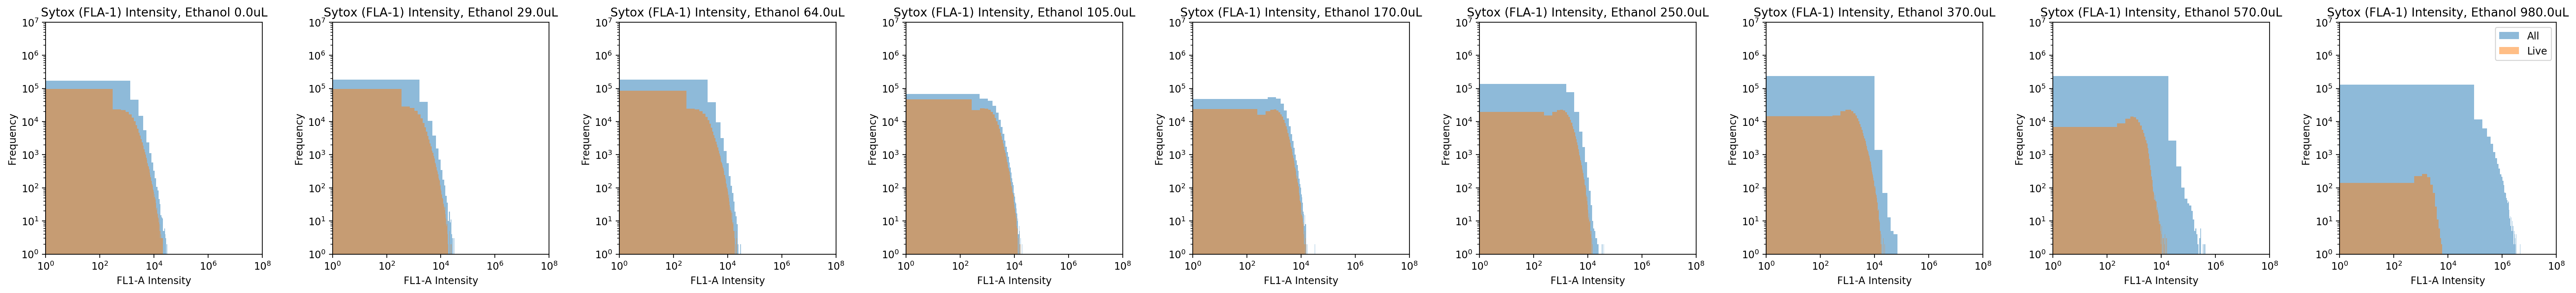

In [85]:
# Get Sytox Levels from a sample and plot as histogram.

volumes=experiment_df.kill_volume.dropna().unique()
volumes.sort()
fig, ax = plt.subplots(nrows=1, ncols=len(volumes), figsize=(4*len(volumes), 4), dpi=200)

live_output_col='live'
#for volume in volumes:
for j, col in enumerate(ax):
    volume = volumes[j]
    #for rs in plot_df.kill.unique():
    df = experiment_df.loc[experiment_df['kill_volume']==volume]

    xvals=df['FL1-A']
    #xvals=df['kill']


    col.set_xlabel("FL1-A Intensity")
    col.set_ylabel("Frequency")

    #col.scatter(xvals, yvals,s=100, alpha=0.5)
    col.hist(df['FL1-A'], bins=100, alpha=0.5, label="All")
    col.hist(df.loc[df[live_output_col]==1]['FL1-A'], bins=100, alpha=0.5, label="Live")
    lims = [ .65, 1
    ]

    #col.plot(lims, lims, 'k-', alpha=0.1, zorder=0)
    col.set_title("Sytox (FLA-1) Intensity, Ethanol " + str(volume) + "uL")
    col.set_yscale('log')
    col.set_xscale('log')
    col.set_xlim([1, 10e7])
    col.set_ylim([1, 10e6])
    #col.set(adjustable='box', aspect='equal')
    #plt.axis([0.85, 1, 0.85, 1])
    plt.legend()
    #plt.axis('equal')
    #plt.gca().set_aspect('equal', adjustable='box')

#plt.axis([0, 10e7, 0, 10e6])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


